# Forum 2 - From Metadata to Insights

Author: Jonathon Mote, PhD - Weather Program Office
September 2025

This tutorial is designed for social scientists who want to explore how their own data might begin to interface with weather and hazard datasets.  The tutorial will provide a quick overview of Jupyter notebooks and tools, some geospatial tools, and the use of APIs to access data.

### What we'll do in the notebook:
1.  **Work with APIs** to search for, access, and download data programmatically
2.  Organize, explore, and download datasets interactively using python libraries like **pandas** and **requests**.
3.  Merge survey data with external data from the **Iowa Environmental Mesonet**
4.  Apply **geospatial tools** to handle location-based data
5.  Create clear, reproducible **visualizations** and **statistical analyses** directly alongside your analysis
6.  Document our process in a way that combines code, results, and explanation all in one place  

### The Steps We Will Follow

<div style="display:flex; flex-direction:column; align-items:center; gap:14px; margin:14px 0 6px 0;">

  <!-- Step 1 -->
  <div style="width:100%; max-width:900px; height:120px; background:#d0eff8; color:#ffffff; border-radius:12px;
              display:flex; align-items:center; justify-content:center; text-align:center;
              padding:0 20px; box-sizing:border-box; font-weight:700; line-height:1.3; font-size:20px;">
    Step 1: Use an API to explore a repository, view metadata, and "pull" social data
  </div>
  <div style="width:2px; height:28px; background:#bfbfbf; border-radius:1px;"></div>

  <!-- Step 2 -->
  <div style="width:100%; max-width:900px; height:120px; background:#0069af; color:#ffffff; border-radius:12px;
              display:flex; align-items:center; justify-content:center; text-align:center;
              padding:0 20px; box-sizing:border-box; font-weight:700; line-height:1.3; font-size:20px;">
    Step 2: Use an API to "pull" weather data
  </div>
  <div style="width:2px; height:28px; background:#bfbfbf; border-radius:1px;"></div>

  <!-- Step 3 -->
  <div style="width:100%; max-width:900px; height:120px; background:#004b98; color:#ffffff; border-radius:12px;
              display:flex; align-items:center; justify-content:center; text-align:center;
              padding:0 20px; box-sizing:border-box; font-weight:700; line-height:1.3; font-size:20px;">
    Step 3: Merge weather data and social data
  </div>
  <div style="width:2px; height:28px; background:#bfbfbf; border-radius:1px;"></div>

  <!-- Step 4 -->
  <div style="width:100%; max-width:900px; height:120px; background:#003087; color:#ffffff; border-radius:12px;
              display:flex; align-items:center; justify-content:center; text-align:center;
              padding:0 20px; box-sizing:border-box; font-weight:700; line-height:1.3; font-size:20px;">
    Step 4: Visualize and analyze the combined dataset
  </div>

</div>



## Stop!  Think About Your Own Data 

Thinking about your data, what types of weather-related data might bring additional insights?  What are some questions that you're interested in? 
#### **>>Respond in the chat<<**

<h2><span style="color:red">Our Research Question Today</span></h2>

For the purposes of this tutorial, we will explore the following question: does exposure to watches, warnings, and advisories have an impact on survey responses to weather risk perception.  Eventually, we will focus on flood warnings, watches, and advisories.

### Before We Get Started - Workplace Setup (Imports)

In Jupyter, there are a large number of python-based "libraries" or "packages" that help with data loading, transformation, and analysis.  These libraries provide tools that help us do things like make graphs, work with data, or do more complex calculations, like regression.  It's good practice to have all libraries imported at the beginning.  You can always add (even install) libraries as you go along, you just have to rerun the cells (or restart the *kernel* if a new install).  

To run a cell, you can go to **"Run"** in the Jupyter menu and select **"Run selected cell"**.  However, it is easier to click on the chevron (▶️) in the editing menu.  There are also keyboard shortcuts like **Shift+Enter** or **Ctrl+Enter**.

In this tutorial, we are going to use a variety of libraries that can be grouped in the following categories:

*Data Handling*

- **pandas**: For working with tabular data in DataFrames.  It is commonly imported with an alias (pd), so we don't constantly have to type out pandas.
- **requests**: For easily fetching data from web APIs and URLs (using GET, POST, etc).
- **timedelta**: Imported from the datetime library, for representing time intervals.
- **BytesIO**: Imported from the IO library, for treating in-memory bytes like a file for reading.
- **ast**: A python module which can be used for evaluating strings.

*Geospatial*

- **geopandas**: To work with geospatial data, allowing us to perform spatial operations and handle geometries such as points, polygons, and lines.
- **Point**: Imported from Shapely, for creating geometric points for mapping.

*Visualization*

- **Pyplot**: Imported from MatPlotLib using the alias "plt", for making simple customizable  plots and charts.
- **Seaborn**: Imported using the alias "sns", for making better looking visualizations.
  
*Utilities*

- **time**: Provides functions for working with time, such as measuring durations, pausing executions, and accessing system time.
- **tqdm**: Adds progress bars to loops for tracking execution.
- **IPython.display**: Renders python results in HTML

*Statistical Modeling/Inference*

- **scipy.stats.chi2_contingency**: Imported from Scipy, to run a chi-square test of independence to check if two categorical variables are related.
- **statsmodels.api as sm**: Imported with the alias "sm", it provides tools for statistical models, including logistic regression.
- **OrderedModel**: Imported from statsmodels, used for ordinal logistic regression models when outcomes are ordered categories.

In [1]:
#import libraries

# data handling
import pandas as pd
import requests
from datetime import timedelta
from io import BytesIO
from collections import Counter
import ast

# geospatial
import geopandas as gpd
from shapely.geometry import Point

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#utilities
import time
from tqdm import tqdm
from IPython.display import display, HTML

#statistical modeling/inference
from scipy.stats import chi2_contingency        
import statsmodels.api as sm                    
from statsmodels.miscmodels.ordinal_model import OrderedModel 

<div style="background-color:#0085ca66; color:white; padding:20px; border-radius:10px; text-align:center; font-size:28px; font-weight:bold;">
  Step 1
</div>

## Step 1: Use an API to explore a repository, view metadata, and download data

In this step, we will explore API access to a data repository, the Harvard Dataverse.  An API (Application Programming Interface) is just a set of rules and tools that allows different software and servers to communicate and interact with each other.  In this case, we want our Jupyter notebook to interact with the Harvard Databerse server for information on datasets.  We use the python library "Requests" to simplify and automate our requests, and Dataverse returns what we requested (hopefully), typically in a format called JSON.  We then use Pandas to transform the JSON in a dataframe, making the results easier to read and manipulate.  

- **Note**: Not all APIs are the same and there might be differences across repositories and data servers.  Be sure to check each API's documentation for how to get started, authentication, search and data access, and more.  For Harvard's Dataverse, the [Dataverse API Guide](https://guides.dataverse.org/en/latest/api/index.html) is a comprehensive, up-to-date documentation for all operations in Harvard’s Dataverse.

- **Another Note**: Ensure that the API is open access, or whether you need an **API key** for restricted access.  An API key is a unique code generated by the data provider that allows users to authenticate and access the data.  For this tutorial, the APIs do not require an API key.


#### Simple search for 10 results

By default, the Harvard Dataverse only returns 10 results per search request.

In [3]:
# Define search query
query = "ripberger"
search_url = f"https://dataverse.harvard.edu/api/search?q={query}&type=dataset"

# Perform search and show JSON
response = requests.get(search_url)
results = response.json()
results  # Display raw JSON output

{'status': 'OK',
 'data': {'q': 'ripberger',
  'total_count': 39,
  'start': 0,
  'spelling_alternatives': {},
  'items': [{'name': 'A comprehensive inventory and review of color in meteorological graphics',
    'type': 'dataset',
    'url': 'https://doi.org/10.7910/DVN/IFBAZ4',
    'global_id': 'doi:10.7910/DVN/IFBAZ4',
    'description': 'This dataset contains an inventory of colors used in 194 meteorological graphics produced by the U.S. National Centers for Environmental Prediction (NCEP). The graphics were collected between August 1, 2023, and November 9, 2023.',
    'published_at': '2025-04-22T13:26:32Z',
    'publisher': 'Harvard Dataverse',
    'citationHtml': 'Ripberger, Joseph; Bitterman, Abby; Rosen, Zoey, 2025, "A comprehensive inventory and review of color in meteorological graphics", <a href="https://doi.org/10.7910/DVN/IFBAZ4" target="_blank">https://doi.org/10.7910/DVN/IFBAZ4</a>, Harvard Dataverse, V1, UNF:6:oGV2BM/aXuWgINpEP53sTQ== [fileUNF]',
    'identifier_of_datav

#### Transform the JSON results

We can easily transform the JSON results into a more readable format, a Pandas dataframe.  This bit of code we can keep separate or build into any cells where the results are returned in JSON.

In [5]:
# Extract items and load into DataFrame
items = results['data']['items']
df_results = pd.DataFrame(items)

# Preview first 5 rows
df_results.head()

,name,type,url,global_id,description,published_at,publisher,citationHtml,identifier_of_dataverse,name_of_dataverse,...,versionState,majorVersion,minorVersion,createdAt,updatedAt,contacts,publications,authors,image_url,keywords
0,A comprehensive inventory and review of color ...,dataset,https://doi.org/10.7910/DVN/IFBAZ4,doi:10.7910/DVN/IFBAZ4,This dataset contains an inventory of colors u...,2025-04-22T13:26:32Z,Harvard Dataverse,"Ripberger, Joseph; Bitterman, Abby; Rosen, Zoe...",harvard,Harvard Dataverse,...,RELEASED,1,0,2025-03-27T13:54:15Z,2025-04-22T13:26:32Z,"[{'name': 'Ripberger, Joseph', 'affiliation': ...",[{}],"[Ripberger, Joseph, Bitterman, Abby, Rosen, Zoey]",NaN,NaN
1,S3OK Surveys,dataset,https://doi.org/10.7910/DVN/JHLMBU,doi:10.7910/DVN/JHLMBU,This repository contains data and accompanying...,2025-08-29T11:02:55Z,The Oklahoma Meso-Scale Integrated Socio-Geogr...,"Ripberger, Joseph; Jenkins-Smith, Hank; Carlso...",msisnet,The Oklahoma Meso-Scale Integrated Socio-Geogr...,...,RELEASED,1,0,2025-08-26T18:21:10Z,2025-08-29T11:02:55Z,"[{'name': 'Ripberger, Joseph', 'affiliation': ...",[{}],"[Ripberger, Joseph, Ripberger, Joseph, Jenkins...",https://dataverse.harvard.edu/api/datasets/120...,NaN
2,WX18,dataset,https://doi.org/10.7910/DVN/RHT4ON,doi:10.7910/DVN/RHT4ON,The Severe Weather and Society Survey (WX) was...,2020-02-03T22:11:23Z,Extreme Weather and Society Survey,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith...",wxsurvey,Extreme Weather and Society Survey,...,RELEASED,1,1,2020-01-13T14:26:39Z,2020-09-01T14:43:00Z,"[{'name': 'Ripberger, Joseph', 'affiliation': ...",[{}],"[Ripberger, Joseph, Silva, Carol, Jenkins-Smit...",https://dataverse.harvard.edu/api/datasets/365...,NaN
3,WX19,dataset,https://doi.org/10.7910/DVN/MLCJEW,doi:10.7910/DVN/MLCJEW,The Severe Weather and Society Survey (WX) was...,2020-02-03T22:10:59Z,Extreme Weather and Society Survey,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith...",wxsurvey,Extreme Weather and Society Survey,...,RELEASED,1,1,2020-01-13T14:28:14Z,2020-09-01T14:43:57Z,"[{'name': 'Ripberger, Joseph', 'affiliation': ...",[{}],"[Ripberger, Joseph, Silva, Carol, Jenkins-Smit...",https://dataverse.harvard.edu/api/datasets/365...,NaN
4,WX17,dataset,https://doi.org/10.7910/DVN/GSTYK4,doi:10.7910/DVN/GSTYK4,The Severe Weather and Society Survey (WX17) w...,2020-02-03T22:10:34Z,Extreme Weather and Society Survey,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith...",wxsurvey,Extreme Weather and Society Survey,...,RELEASED,1,1,2020-01-28T20:00:17Z,2020-09-01T14:41:58Z,"[{'name': 'Ripberger, Joseph', 'affiliation': ...",[{}],"[Ripberger, Joseph, Silva, Carol, Jenkins-Smit...",https://dataverse.harvard.edu/api/datasets/367...,NaN


#### Let's examine that 'description' a little more

In [13]:
pd.set_option("display.max_colwidth", None)

display(HTML("""
<style>
.dataframe td {
  white-space: normal !important;
  word-wrap: break-word;
  max-width: 400px;
}
</style>
"""))

df_results[["name", "description"]].head()

,name,description
0,A comprehensive inventory and review of color in meteorological graphics,"This dataset contains an inventory of colors used in 194 meteorological graphics produced by the U.S. National Centers for Environmental Prediction (NCEP). The graphics were collected between August 1, 2023, and November 9, 2023."
1,S3OK Surveys,"This repository contains data and accompanying metadata (including survey instruments) from the S3OK component of the Oklahoma Meso-Scale Integrated Socio-Geographic Network (M-SISNet) survey. The S3OK project focused on developing socially sustainable solutions for water, carbon, and infrastructure resilience in Oklahoma. The survey was conducted in a panel format, with the same respondents surveyed across multiple waves over time. Additional data and metadata will be added to this repository as new waves are completed."
2,WX18,"The Severe Weather and Society Survey (WX) was designed and administered by the Center for Risk and Crisis Management (CRCM) at the University of Oklahoma. This is the second survey in the annual series (see Silva et al., 2017 for information on WX17). WX18 was fielded July 6-11, 2018 using an online questionnaire that was completed by 3,000 U.S. adults (age 18+) that were recruited from an Internet panel that matches the characteristics of the U.S. population as estimated in the U.S. Census. Following WX17, which was designed to establish baseline measures of the extent to which U.S. adults receive, understand, and respond to severe weather forecasts and warnings, WX18 was designed to continue and, in some cases, refine the measurement of these concepts. Additionally, WX18 measured public trust in the National Weather Service (NWS), extreme weather and climate risk perceptions, risk literacy, interpretations of probabilistic language, and response efficacy."
3,WX19,"The Severe Weather and Society Survey (WX) was designed and administered by the Center for Risk and Crisis Management (CRCM) at the University of Oklahoma. This is the third survey in the annual series (see Silva et al. 2017 and Silva et al. 2018 for information on WX17 and WX18). WX19 was fielded June 24 – July 6, 2019 using an online questionnaire that was completed by 3,006 U.S. adults (age 18+) that were recruited from an Internet panel that matches the characteristics of the U.S. population as estimated in the U.S. Census. Following WX17 and WX18, which were designed to establish baseline measures of the extent to which U.S. adults receive, understand, and respond to severe weather forecasts and warnings, WX19 was designed to continue and, in some cases, refine the measurement of these concepts. Additionally, WX19 measured public trust in the National Weather Service (NWS), extreme weather and climate risk perceptions, risk literacy, interpretations of probabilistic language, and extreme weather preparedness."
4,WX17,"The Severe Weather and Society Survey (WX17) was designed and administered by the Center for Risk and Crisis Management (CRCM) at the University of Oklahoma. WX17 was fielded in June 2017 using an online questionnaire that was completed by 2,009 U.S. adults (age 18+) that were recruited from an Internet panel that matches the characteristics of the U.S. population as estimated in the U.S. Census. The survey was designed to establish baseline measures of the extent to which U.S. adults receive, understand, and respond to severe weather forecasts and warnings. Additionally, the survey measured public preferences about tradeoffs during the forecast process (e.g., lead time vs. accuracy/precision of warnings), trust in the National Weather Service (NWS), hazard risk literacy, the relative importance of probability and intensity in risk characterization, and the value of geographically specific and continuous severe weather warnings, such as those envisioned by the Forecasting a Continuum of Environmental Threats (FACETs) framework."


#### Search for more than 10 results

We can make an API call that goes beyond the 10 result limit by creating a **loop**.  The "while True" statement will continue running (10 results at a time) until there are no results remaining.  We collect all of the results in one list using the "extend" command.  Finally, we can limit the dataframe to only view a subset of columns.

In [16]:
query = "ripberger"
start = 0
per_page = 20  # Max per page is 100
all_items = []

while True:
    search_url = (
        f"https://dataverse.harvard.edu/api/search?"
        f"q={query}&type=dataset&start={start}&per_page={per_page}"
    )
    
    response = requests.get(search_url)
    data = response.json()
    
    items = data['data']['items']
    all_items.extend(items)
    
    # Break if fewer than per_page results are returned (i.e., last page)
    if len(items) < per_page:
        break
    start += per_page

# Convert to DataFrame
df_results = pd.DataFrame(all_items)
df_results[['name', 'global_id', 'published_at', 'citation']].head(10)

,name,global_id,published_at,citation
0,A comprehensive inventory and review of color in meteorological graphics,doi:10.7910/DVN/IFBAZ4,2025-04-22T13:26:32Z,"Ripberger, Joseph; Bitterman, Abby; Rosen, Zoey, 2025, ""A comprehensive inventory and review of color in meteorological graphics"", https://doi.org/10.7910/DVN/IFBAZ4, Harvard Dataverse, V1, UNF:6:oGV2BM/aXuWgINpEP53sTQ== [fileUNF]"
1,S3OK Surveys,doi:10.7910/DVN/JHLMBU,2025-08-29T11:02:55Z,"Ripberger, Joseph; Jenkins-Smith, Hank; Carlson, Nina; Henderson, Matt, 2025, ""S3OK Surveys"", https://doi.org/10.7910/DVN/JHLMBU, Harvard Dataverse, V1, UNF:6:aBt+2AybCFwuYyOS5VpwyA== [fileUNF]"
2,WX18,doi:10.7910/DVN/RHT4ON,2020-02-03T22:11:23Z,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith, Hank; Krocak, Makenzie, 2020, ""WX18"", https://doi.org/10.7910/DVN/RHT4ON, Harvard Dataverse, V1, UNF:6:Yyyznfcg+cNLP/7D2v9/wg== [fileUNF]"
3,WX19,doi:10.7910/DVN/MLCJEW,2020-02-03T22:10:59Z,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith, Hank; Krocak, Makenzie, 2020, ""WX19"", https://doi.org/10.7910/DVN/MLCJEW, Harvard Dataverse, V1, UNF:6:VuGLjhYyzRx0N28t1J/LHQ== [fileUNF]"
4,WX17,doi:10.7910/DVN/GSTYK4,2020-02-03T22:10:34Z,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith, Hank; Krocak, Makenzie, 2020, ""WX17"", https://doi.org/10.7910/DVN/GSTYK4, Harvard Dataverse, V1, UNF:6:x2+/QOuNR25/XiOkx3MzIg== [fileUNF]"
5,WX20,doi:10.7910/DVN/EWOCUA,2020-09-01T14:03:39Z,"Ripberger, Joseph; Krocak, Makenzie; Silva, Carol; Jenkins-Smith, Hank, 2020, ""WX20"", https://doi.org/10.7910/DVN/EWOCUA, Harvard Dataverse, V2, UNF:6:+s2ce53I39wFRTp442tBEQ== [fileUNF]"
6,TC21,doi:10.7910/DVN/Q2S7OJ,2022-04-05T14:55:39Z,"Krocak, Makenzie; Ripberger, Joseph; Silva, Carol; Jenkins-Smith, Hank, 2022, ""TC21"", https://doi.org/10.7910/DVN/Q2S7OJ, Harvard Dataverse, V2, UNF:6:c6gXgLQMWXjgC6yBa2bubA== [fileUNF]"
7,WX21,doi:10.7910/DVN/QYZLSO,2022-08-22T20:37:58Z,"Ripberger, Joseph; Krocak, Makenzie; Silva, Carol; Jenkins-Smith, Hank, 2021, ""WX21"", https://doi.org/10.7910/DVN/QYZLSO, Harvard Dataverse, V2, UNF:6:Z2TF/SuLbAgTzrdUBe1+rw== [fileUNF]"
8,TC20,doi:10.7910/DVN/QUO60T,2022-03-16T19:43:24Z,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith, Hank; Allan, Jinan; Krocak, Makenzie, 2022, ""TC20"", https://doi.org/10.7910/DVN/QUO60T, Harvard Dataverse, V2, UNF:6:FawaZS0ZTU6HjFBdel6apw== [fileUNF]"
9,"Replication Data for: ""Seeing lies and laying blame: Partisanship and US public perceptions about disinformation""",doi:10.7910/DVN/PRP4WX,2024-01-24T15:47:54Z,"Kaitlin Peach; Joseph Ripberger; Kuhika Gupta; Andrew Fox; Hank Jenkins-Smith; Carol Silva, 2024, ""Replication Data for: ""Seeing lies and laying blame: Partisanship and US public perceptions about disinformation"""", https://doi.org/10.7910/DVN/PRP4WX, Harvard Dataverse, V1, UNF:6:vrIVJvf7xQUkor0v4gC74A== [fileUNF]"


In [18]:
#How many datasets?  Each row (first number) represents a dataset.
df_results.shape

(39, 26)

### Subsetting Our Results

Let's say we don't want all of these, but only a subset of related surveys.  For this step, we will focus on the yearly waves of the Extreme Weather and Society Survey (WXYY). So let's subset them the dataframe from the earlier API call.

In [24]:
# Define the dataset names you want to filter on
target_names = ["WX17", "WX18", "WX19", "WX20", "WX21", "WX22", "WX23", "WX24"]

# Subset the dataframe
df_subset = df_results[df_results['name'].isin(target_names)]

#Reset colwidth
pd.reset_option("display.max_colwidth")

# Display the result
df_subset.head(5)

,name,type,url,global_id,description,published_at,publisher,citationHtml,identifier_of_dataverse,name_of_dataverse,...,versionState,majorVersion,minorVersion,createdAt,updatedAt,contacts,publications,authors,image_url,keywords
2,WX18,dataset,https://doi.org/10.7910/DVN/RHT4ON,doi:10.7910/DVN/RHT4ON,The Severe Weather and Society Survey (WX) was...,2020-02-03T22:11:23Z,Extreme Weather and Society Survey,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith...",wxsurvey,Extreme Weather and Society Survey,...,RELEASED,1.0,1.0,2020-01-13T14:26:39Z,2020-09-01T14:43:00Z,"[{'name': 'Ripberger, Joseph', 'affiliation': ...",[{}],"[Ripberger, Joseph, Silva, Carol, Jenkins-Smit...",https://dataverse.harvard.edu/api/datasets/365...,NaN
3,WX19,dataset,https://doi.org/10.7910/DVN/MLCJEW,doi:10.7910/DVN/MLCJEW,The Severe Weather and Society Survey (WX) was...,2020-02-03T22:10:59Z,Extreme Weather and Society Survey,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith...",wxsurvey,Extreme Weather and Society Survey,...,RELEASED,1.0,1.0,2020-01-13T14:28:14Z,2020-09-01T14:43:57Z,"[{'name': 'Ripberger, Joseph', 'affiliation': ...",[{}],"[Ripberger, Joseph, Silva, Carol, Jenkins-Smit...",https://dataverse.harvard.edu/api/datasets/365...,NaN
4,WX17,dataset,https://doi.org/10.7910/DVN/GSTYK4,doi:10.7910/DVN/GSTYK4,The Severe Weather and Society Survey (WX17) w...,2020-02-03T22:10:34Z,Extreme Weather and Society Survey,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith...",wxsurvey,Extreme Weather and Society Survey,...,RELEASED,1.0,1.0,2020-01-28T20:00:17Z,2020-09-01T14:41:58Z,"[{'name': 'Ripberger, Joseph', 'affiliation': ...",[{}],"[Ripberger, Joseph, Silva, Carol, Jenkins-Smit...",https://dataverse.harvard.edu/api/datasets/367...,NaN
5,WX20,dataset,https://doi.org/10.7910/DVN/EWOCUA,doi:10.7910/DVN/EWOCUA,The Severe Weather and Society Survey (WX) was...,2020-09-01T14:03:39Z,Extreme Weather and Society Survey,"Ripberger, Joseph; Krocak, Makenzie; Silva, Ca...",wxsurvey,Extreme Weather and Society Survey,...,RELEASED,2.0,1.0,2020-08-05T13:29:07Z,2020-09-01T14:46:05Z,"[{'name': 'Ripberger, Joseph', 'affiliation': ...",[{}],"[Ripberger, Joseph, Krocak, Makenzie, Silva, C...",https://dataverse.harvard.edu/api/datasets/400...,NaN
7,WX21,dataset,https://doi.org/10.7910/DVN/QYZLSO,doi:10.7910/DVN/QYZLSO,The Severe Weather and Society Survey (WX) was...,2022-08-22T20:37:58Z,Extreme Weather and Society Survey,"Ripberger, Joseph; Krocak, Makenzie; Silva, Ca...",wxsurvey,Extreme Weather and Society Survey,...,RELEASED,2.0,0.0,2021-07-08T16:26:55Z,2022-08-22T20:37:58Z,"[{'name': 'Krocak, Makenzie', 'affiliation': '...",NaN,"[Ripberger, Joseph, Krocak, Makenzie, Silva, C...",https://dataverse.harvard.edu/api/datasets/488...,NaN


## Step 1a: Get Dataset Metadata and Files

### Getting metadata for a single dataset

Let's examine the metadata for one of the datasets in the subset, WX18.  There will often be two sets of metadata: file-level (specific to the repository) and data-level (that describes the data---the topic of yesterday's forum).  In this example, we will first look at the file-level metadata that the Dataverse uses.  Next, we will pull the full dataset metadata.  While the results will be in JSON, we will be adding a step that converts them to a Pandas dataframe.

### File level metadata

In [26]:
# Extract persistent ID (DOI) from the first row [0] by position
persistent_id = df_subset.iloc[0]['global_id']

# Get dataset metadata
metadata_url = f"https://dataverse.harvard.edu/api/datasets/:persistentId/?persistentId={persistent_id}"
metadata_response = requests.get(metadata_url).json()

# Get list of files
files = metadata_response['data']['latestVersion']['files']

# Convert list of files to DataFrame
df_files = pd.DataFrame(files)

# Preview first few rows
df_files.head()

,label,restricted,version,datasetVersionId,dataFile
0,WX18_data_wtd.tab,False,1,210551,"{'id': 3657710, 'persistentId': 'doi:10.7910/D..."
1,WX18 Instrument.pdf,False,1,210551,"{'id': 3657709, 'persistentId': 'doi:10.7910/D..."
2,WX18 Reference Report.pdf,False,1,210551,"{'id': 3657708, 'persistentId': 'doi:10.7910/D..."


### Full dataset metadata

This is actually a case of where we want to see the full JSON, to view those aspects of the dataset that are most useful.  In this case, the most relevent information can be found in a description of the dataset.

In [28]:
# Extract persistent ID (DOI) from the first row
persistent_id = df_subset.iloc[0]['global_id']

# Get full dataset metadata (latest version)
metadata_url = f"https://dataverse.harvard.edu/api/datasets/:persistentId/versions/:latest?persistentId={persistent_id}"
metadata_response = requests.get(metadata_url).json()

# Extract list of files from the JSON
files = metadata_response['data']['files']

metadata_response

{'status': 'OK',
 'data': {'id': 210551,
  'datasetId': 3657707,
  'datasetPersistentId': 'doi:10.7910/DVN/RHT4ON',
  'datasetType': 'dataset',
  'storageIdentifier': 's3://10.7910/DVN/RHT4ON',
  'versionNumber': 1,
  'internalVersionNumber': 4,
  'versionMinorNumber': 1,
  'versionState': 'RELEASED',
  'latestVersionPublishingState': 'RELEASED',
  'deaccessionLink': '',
  'UNF': 'UNF:6:Yyyznfcg+cNLP/7D2v9/wg==',
  'lastUpdateTime': '2020-09-01T14:43:00Z',
  'releaseTime': '2020-09-01T14:43:00Z',
  'createTime': '2020-09-01T14:42:39Z',
  'publicationDate': '2020-02-03',
  'citationDate': '2020-02-03',
  'license': {'name': 'CC0 1.0',
   'uri': 'http://creativecommons.org/publicdomain/zero/1.0',
   'iconUri': 'https://licensebuttons.net/p/zero/1.0/88x31.png',
   'rightsIdentifier': 'CC0-1.0',
   'rightsIdentifierScheme': 'SPDX',
   'schemeUri': 'https://spdx.org/licenses/',
   'languageCode': 'en'},
  'fileAccessRequest': False,
  'metadataBlocks': {'citation': {'displayName': 'Citation

## Step 1b: Download a File

From the file-level metadata, we see that the dataset file (.tab) is accompanied by PDFs of the instrument and a reference report.

Let's download the dataset file (.tab) for first year of the survey, WX18, which has a file_id of "3657710".  If you wanted to work with this data for real, you would also want to download the survey instrument and reference document to fully understand the data.

In [30]:
# File ID for WxEM_Wave1.tab
file_id = 3657710

# API call and download directly to memory
file_url = f"https://dataverse.harvard.edu/api/access/datafile/{file_id}?format=original"
response = requests.get(file_url)

# Load into pandas directly from memory, assuming comma-delimited content
df_18 = pd.read_csv(BytesIO(response.content), sep=',', encoding='ISO-8859-1', engine='python', on_bad_lines='skip')
df_18.head()

,p_id,age,age_group,gend,hisp,race,state,zip,nws_region,lat,...,begin_datetime,end_datetime,begin_date,end_date,begin_time,end_time,time_taken,censusproportion,surveyproportion,weightfactor
0,EPO77VBNDHYXC5L4M3,54,4,1,0,4,Illinois,60060,Central Region,42.200806,...,1530900028,1530900853,2018-07-06,2018-07-06,13:00:00,13:14:00,13,0.001122,0.003155,0.355626
1,EPO77VDZDV5LMGD4M9,66,6,0,0,1,Maryland,21921,Eastern Region,39.575394,...,1530900035,1530901159,2018-07-06,2018-07-06,13:00:00,13:19:00,18,0.027792,0.032461,0.856166
2,EPO77VFD67MR5R44M7,54,4,1,0,1,New York,14420,Eastern Region,43.250793,...,1530900046,1530900927,2018-07-06,2018-07-06,13:00:00,13:15:00,14,0.030340,0.057592,0.526809
3,EPO77VFJ2CJKML44M9,56,5,1,0,1,Utah,84097,Western Region,40.296799,...,1530900046,1530900878,2018-07-06,2018-07-06,13:00:00,13:14:00,13,0.024319,0.034826,0.698300
4,EPO77VFD4CZHV2M4M0,66,6,1,0,1,California,90620,Western Region,33.875504,...,1530900048,1530900993,2018-07-06,2018-07-06,13:00:00,13:16:00,15,0.020574,0.023217,0.886161


### Examine the dataset

Pandas has a number of attributes that can be used to quickly examine characteristics of the dataset, things like size, shape, value distributions, basic stats, and missing values...anything you would normally do to check a dataset.  Below, I am just going to run a few of them.

In [33]:
# See basic shape of the data (rows, columns).  Each row represents a respondent.

df_18.shape

(3000, 223)

In [35]:
# See quick summary statistics

df_18.describe()

,age,age_group,gend,hisp,race,zip,lat,lon,long_years,long_months,...,oft_twit,oft_FB,ign_instruct,is_bluedot,begin_datetime,end_datetime,time_taken,censusproportion,surveyproportion,weightfactor
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,2986.000000,2995.000000,2548.000000,441.0,3.000000e+03,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000
mean,46.848000,3.672000,0.486667,0.163333,1.515000,50249.611000,37.372934,-91.077331,26.346667,21.698833,...,1.630610,3.698831,1.105573,1.0,1.531090e+09,1.531092e+09,34.997667,0.017732,0.022435,0.935461
std,17.095701,1.688401,0.499906,0.369731,1.208137,29599.090893,5.247986,15.748561,288.801880,677.357349,...,2.213069,2.336457,0.425254,0.0,1.045842e+05,1.045703e+05,236.781662,0.010795,0.016075,0.707920
min,18.000000,1.000000,0.000000,0.000000,1.000000,716.000000,10.500000,-145.612000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.0,1.530900e+09,1.530901e+09,10.000000,0.000016,0.001047,0.012780
25%,32.000000,2.000000,0.000000,0.000000,1.000000,27609.250000,33.804703,-97.821999,4.000000,1.000000,...,0.000000,1.000000,1.000000,1.0,1.530985e+09,1.530988e+09,14.000000,0.006619,0.007886,0.594824
50%,47.000000,4.000000,0.000000,0.000000,1.000000,46341.000000,38.635750,-85.886200,10.000000,4.000000,...,0.000000,5.000000,1.000000,1.0,1.531162e+09,1.531164e+09,19.000000,0.020845,0.022082,0.784617
75%,62.000000,5.000000,1.000000,0.000000,1.000000,78043.500000,41.134293,-79.855425,21.000000,7.000000,...,4.000000,6.000000,1.000000,1.0,1.531171e+09,1.531173e+09,27.000000,0.025745,0.032541,1.115311
max,87.000000,6.000000,1.000000,1.000000,7.000000,99354.000000,60.791702,-60.750000,14400.000000,33180.000000,...,6.000000,6.000000,3.000000,1.0,1.531338e+09,1.531339e+09,9931.000000,0.048527,0.059686,14.620821


In [37]:
# Get a quick count of missing data by column

df_18.isnull().sum()

p_id                0
age                 0
age_group           0
gend                0
hisp                0
                   ..
end_time            0
time_taken          0
censusproportion    0
surveyproportion    0
weightfactor        0
Length: 223, dtype: int64

#### Variable names

Next, we will list the columns to show all the variable names contained in the data.  To integrate with weather data, we are most interested in locating possible ways to join the data.  Typically, geographic variables are a good start. 

<h2><span style="color:red">Stop!  After we run the next cell, do you see any geographic variables that might be useful?</span></h2>

#### **>>Respond in the chat<<**

In [40]:
# List all column names
df_18.columns.tolist()

['p_id',
 'age',
 'age_group',
 'gend',
 'hisp',
 'race',
 'state',
 'zip',
 'nws_region',
 'lat',
 'lon',
 'long_years',
 'long_months',
 'last_state',
 'now',
 'rural',
 'home',
 'home_spec',
 'rent',
 'adults',
 'children',
 'follow',
 'plan_around',
 'und_weather',
 'risk_wind',
 'risk_rain',
 'risk_heat',
 'risk_drought',
 'risk_cold',
 'risk_snow',
 'risk_tor',
 'risk_flood',
 'risk_hur',
 'risk_fire',
 'risk_tie',
 'alert_und',
 'tortrack',
 'torwatch',
 'torwarn',
 'warn_prob_area',
 'prob_dist',
 'warn_prob_house',
 'warn_cons',
 'warn_time',
 'warn_size',
 'warn_time_minutes',
 'warn_time_hours',
 'watch_prob_area',
 'watch_prob_house',
 'watch_cons',
 'watch_time',
 'watch_size',
 'watch_time_minutes',
 'watch_time_hours',
 'tor_watchwarn_und',
 'tor_map_und',
 'tor_radar_und',
 'svr_hail',
 'svr_wind',
 'svr_lightning',
 'svr_flood',
 'svr_rain',
 'svr_watchwarn_und',
 'rec_all',
 'rec_most',
 'rec_soon',
 'rec_miss',
 'rec_area',
 'rec_time',
 'rec_sleep',
 'rec_driving',


In this survey, some good possible variables are state, zip, and lat/lon. These are pretty straightforward, but I'm also curious about "nws_region"? What does it contain? Let's take a look!

In [42]:
#Is nws_region usefl at all?
df_18['nws_region'].unique()

array(['Central Region', 'Eastern Region', 'Western Region',
       'Southern Region', nan], dtype=object)

##### Unfortunately, "nws_region" only has four regions.  Nonetheless, it might be useful for a different research question.  

### For our purposes, we will focus 'lat'/'lon' for location.  And we'll use begin_date to identify three days prior to beginning the survey.

<div style="background-color:#0069afff; color:white; padding:20px; border-radius:10px; text-align:center; font-size:28px; font-weight:bold;">
  Step 2
</div>

## Step 2: Use an API to download weather data

First, we will demonstrate how the Iowa Mesonet API can be used to collect weather alerts for each survey respondent.  Since calling an API can be slow and depends on internet access, we have already pre-downloaded the weather data needed for this analysis.  

Next, we will take this pre-loaded weather data and merge it with the survey responses so that each person’s record includes both their answers and the relevant weather alerts.  


### Iowa Mesonet API - DO NOT RUN AT THIS TIME

The code below is doing alot of work, going through the survey data **one person/row at a time** and asking the Iowa Mesonet API:  

“Given this person’s location and survey date, what watches, warnings, or advisories (WWAs) were active in the few days leading up to that date?”  

**Analogy:** This is like calling a weather hotline for each person’s hometown and writing down any recent alerts next to their name in the survey spreadsheet.  

Here’s what happens step by step:  

1. **Make sure the date is in the right format.**  
   The `begin_date` column is converted into a standard date format so the computer can work with it (it's a precaution). 

2. **Prepare a place to store the results.**  
   A new column called `wwa_names` is added to the survey data. This will eventually hold a *list* of weather alerts for each person.  In Python, you can think of a list as a flexible container that holds a collection of items.

3. **Go through each respondent one by one.**  
   For each person, we:  
   - Look up their latitude, longitude, and survey date.  
   - Define a **3-day window** before their survey date (so we catch recent alerts).  
   - Build a request to the Iowa Mesonet API using their location and dates.  


4. **Ask the API for weather alerts.**  
   - If the API responds successfully, we pull out the names of any alerts and save them in that person’s row.  
   - If something goes wrong (bad connection, no data, etc.), we save an *empty list* for that person.
   - The API call will continue until we run out of survey respondents.  

The resulting dataset (`df_18`) has a new column called `wwa_names` that tells us which WWAs (if any) each respondent experienced around the time of their survey.  

Please note the API Endpoint (Rest-like) and the structure of the request for those variables:

https://mesonet.agron.iastate.edu/vtec/json.php?lon={lon}&lat={lat}&sdate={start}&edate={end}

Remember, you can always check the API documentation for guidance: the [Iowa Mesonet API Guide](https://mesonet.agron.iastate.edu/api/).

**Note:  We will not run this API call during the webinar because it takes about 20-30 minutes to download the data. If you want to try this after the webinar, just remove the first line ('''python) and run the cell.**

In [ ]:
'''python

# Make sure begin_date is in datetime format
df_18['begin_date'] = pd.to_datetime(df_18['begin_date'])

# New column to store list of WWA names
df_18['wwa_names'] = None

# Loop through each respondent
for idx, row in tqdm(df_18.iterrows(), total=len(df_18)):
    lat = row['lat']
    lon = row['lon']
    end_date = row['begin_date']
    start_date = end_date - timedelta(days=3)

    # Build API URL with small buffer
    url = (
        f"https://mesonet.agron.iastate.edu/json/vtec_events_bypoint.py"
        f"?lat={lat}&lon={lon}"
        f"&sdate={start_date.strftime('%Y-%m-%d')}&edate={end_date.strftime('%Y-%m-%d')}"
        f"&buffer=0.1"
    )

    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            names = [event['name'] for event in data.get('events', [])]
            df_18.at[idx, 'wwa_names'] = names
        else:
            df_18.at[idx, 'wwa_names'] = []
    except Exception as e:
        print(f"Failed for idx={idx}, lat={lat}, lon={lon}: {e}")
        df_18.at[idx, 'wwa_names'] = []


<div style="background-color:#004b98ff; color:white; padding:20px; border-radius:10px; text-align:center; font-size:28px; font-weight:bold;">
  Step 3
</div>


### Step 3 - Joining the Survey Data with Weather Alerts

Prior to the webinar, the data we needed was downloaded in a csv file and stored in Github.  This dataset ('wwa_by_pid') includes the respondent identifier ('p_id') and a column with watches, warnings, and advisories ('wwa_names') in a list.  At this point, we have two different tables of data that we need to merge:

- **Survey data** (df_18): this has all the survey responses, including their p_id (a unique identifier for each person).

- **Weather alerts data** (lk): this has just two columns — the same p_id, and the list of watches, warnings, or advisories (wwa_names) that each person experienced.

We're going to do a left merge on both tables using p_id, which is basically doing the following: 

**“For each person (p_id) in the survey data, look up their matching p_id in the weather file and bring in the weather alerts column (wwa_names).”**

##### If you ran the API call in Step 2, you should skip the next two cells. 

In [46]:
# If you have run the API, you should skip this cell

url = "https://raw.githubusercontent.com/jmote-noaa/Data-Forums/refs/heads/main/data/wwa_by_pid.csv"
lk = pd.read_csv(url)

# Merge with the original df_18 on 'p_id'
df_18 = df_18.merge(lk, on="p_id", how="left")

In [48]:
# We use `ast` to convert the `wwa_names` column from text back into real Python lists so we can work with them.  
df_18['wwa_names'] = df_18['wwa_names'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

##### If you ran the API call in Step 2, you can resume here.

In [51]:
# Let's take a quick look at the new, combined dataset
df_18.head(5)

,p_id,age,age_group,gend,hisp,race,state,zip,nws_region,lat,...,end_datetime,begin_date,end_date,begin_time,end_time,time_taken,censusproportion,surveyproportion,weightfactor,wwa_names
0,EPO77VBNDHYXC5L4M3,54,4,1,0,4,Illinois,60060,Central Region,42.200806,...,1530900853,2018-07-06,2018-07-06,13:00:00,13:14:00,13,0.001122,0.003155,0.355626,"[Severe Thunderstorm Warning, Flood Advisory, ..."
1,EPO77VDZDV5LMGD4M9,66,6,0,0,1,Maryland,21921,Eastern Region,39.575394,...,1530901159,2018-07-06,2018-07-06,13:00:00,13:19:00,18,0.027792,0.032461,0.856166,"[Severe Thunderstorm Warning, Flash Flood Warn..."
2,EPO77VFD67MR5R44M7,54,4,1,0,1,New York,14420,Eastern Region,43.250793,...,1530900927,2018-07-06,2018-07-06,13:00:00,13:15:00,14,0.030340,0.057592,0.526809,"[Heat Advisory, Heat Advisory, Heat Advisory, ..."
3,EPO77VFJ2CJKML44M9,56,5,1,0,1,Utah,84097,Western Region,40.296799,...,1530900878,2018-07-06,2018-07-06,13:00:00,13:14:00,13,0.024319,0.034826,0.698300,"[Red Flag Warning, Fire Weather Watch]"
4,EPO77VFD4CZHV2M4M0,66,6,1,0,1,California,90620,Western Region,33.875504,...,1530900993,2018-07-06,2018-07-06,13:00:00,13:16:00,15,0.020574,0.023217,0.886161,"[Beach Hazard Statement, High Surf Advisory]"


In [53]:
# We can subset the dataframe to focus only on the variables we want to see.  We use the attribute "dropna" to make sure that there are no rows that are empty (i.e., we didn't screw something up).
df_18[['p_id','lat', 'lon', 'begin_date', 'wwa_names']].dropna().head(10)

,p_id,lat,lon,begin_date,wwa_names
0,EPO77VBNDHYXC5L4M3,42.200806,-88.042999,2018-07-06,"[Severe Thunderstorm Warning, Flood Advisory, ..."
1,EPO77VDZDV5LMGD4M9,39.575394,-75.926903,2018-07-06,"[Severe Thunderstorm Warning, Flash Flood Warn..."
2,EPO77VFD67MR5R44M7,43.250793,-77.924599,2018-07-06,"[Heat Advisory, Heat Advisory, Heat Advisory, ..."
3,EPO77VFJ2CJKML44M9,40.296799,-111.676102,2018-07-06,"[Red Flag Warning, Fire Weather Watch]"
4,EPO77VFD4CZHV2M4M0,33.875504,-117.993500,2018-07-06,"[Beach Hazard Statement, High Surf Advisory]"
5,EPO77VFJNC6WZGC4M2,40.626495,-106.927200,2018-07-06,[]
6,EPO77VFK7YV6PSP4M2,32.719101,-117.160706,2018-07-06,"[High Surf Advisory, Beach Hazard Statement]"
7,EPO77VFJCRK7C6D4M1,38.914200,-104.774902,2018-07-06,"[Red Flag Warning, Red Flag Warning, Red Flag ..."
8,EPO77VFNLZ7JM894M7,35.515106,-97.574097,2018-07-06,"[Heat Advisory, Heat Advisory]"
9,EPO77VFPD6RK7Q34M6,39.739197,-104.984703,2018-07-06,"[Severe Thunderstorm Warning, Severe Thunderst..."


In [55]:
#let's make sure we have the same number of row that we started with.  It should be 3,000
df_18.shape

(3000, 224)

In [57]:
#how many respondents experienced watches/warnings/advisories?
df_18['wwa_names'].apply(lambda x: isinstance(x, list) and len(x) > 0).sum()

1713

In [59]:
#who received more than two?
df_18[df_18['wwa_names'].apply(lambda x: isinstance(x, list) and len(x) > 2)
][['p_id','lat', 'lon', 'begin_date', 'wwa_names']]

,p_id,lat,lon,begin_date,wwa_names
0,EPO77VBNDHYXC5L4M3,42.200806,-88.042999,2018-07-06,"[Severe Thunderstorm Warning, Flood Advisory, ..."
1,EPO77VDZDV5LMGD4M9,39.575394,-75.926903,2018-07-06,"[Severe Thunderstorm Warning, Flash Flood Warn..."
2,EPO77VFD67MR5R44M7,43.250793,-77.924599,2018-07-06,"[Heat Advisory, Heat Advisory, Heat Advisory, ..."
7,EPO77VFJCRK7C6D4M1,38.914200,-104.774902,2018-07-06,"[Red Flag Warning, Red Flag Warning, Red Flag ..."
9,EPO77VFPD6RK7Q34M6,39.739197,-104.984703,2018-07-06,"[Severe Thunderstorm Warning, Severe Thunderst..."
...,...,...,...,...,...
2988,EPO7G8BT7JX3KCF4M3,33.448807,-111.801399,2018-07-09,"[Dust Storm Advisory, Dust Storm Advisory, Dus..."
2989,EPO7F42L8RVZDWR4M5,40.896301,-74.151299,2018-07-09,"[Flash Flood Watch, Flash Flood Watch, Flash F..."
2993,EPO7DCDTKZXQBYN4M7,40.776901,-73.981300,2018-07-09,"[Flash Flood Watch, Flash Flood Watch, Flash F..."
2994,EPO7DLJRWRC7HF54M8,40.714294,-74.005997,2018-07-09,"[Flash Flood Watch, Flash Flood Watch, Flash F..."


### Step 3a: Exporting the Data for Use Outside Jupyter

Now that we have a merged dataframe (df_18) containing both survey responses and weather alerts, we can save and download it in different formats for use in other tools and workflows. Jupyter is excellent for exploring, cleaning, and manipulating data, but once you’ve shaped the dataset you want, you may prefer to bring it back into your regular workflow — whether that’s statistical software, spreadsheets, or visualization platforms. We won’t actually run the save commands here, but I’ll provide the code snippets so you can see how it’s done.

**CSV (general use--Excel, R, SAS, SPSS, STATA)**

In [ ]:
#df_18.to_csv("survey_weather.csv", index=False)

**Parquet (general use--generally for larger datasets)**

In [ ]:
#df_18.to_parquet("survey_weather.parquet")

<div style="background-color:#fb1e1eff; color:white; padding:20px; border-radius:10px; text-align:center; font-size:28px; font-weight:bold;">
  Stop!  Take a break! 
</div>

<div style="background-color:#003087ff; color:white; padding:20px; border-radius:10px; text-align:center; font-size:28px; font-weight:bold;">
  Step 4
</div>



### Step 4: Exploring the Combined Dataset

After you download the new dataset, you could easily just jump back into your regular workflow.  But let's say we want to continue in Jupyter to quickly visualize and analyze the data to examine the data for any insights.  Below we will look at the following:

- ***Quick Visualizations***
- ***Visualizing WWAs by Survey Responses***
- ***Quick Statistical Analyses***
- ***A Bit More Involved Analysis***

#### Step 4a: Quick visualizations

In this step, I'll go over the first visualization and show the code for the remaining two:

1. A geomap of survey respondents by number of watches and warnings 3 days prior to the survey.
2. A bar chart showing frequency of types of watches and warnings.
3. A line graph showing frequency of types of watches and warning over time.

Jupyter (and Python) provide access to a wide range of powerful visualization libraries — from simple plotting with **matplotlib** and **seaborn** to interactive mapping with **folium** or **plotly** — giving you many options for exploring and presenting your data.  

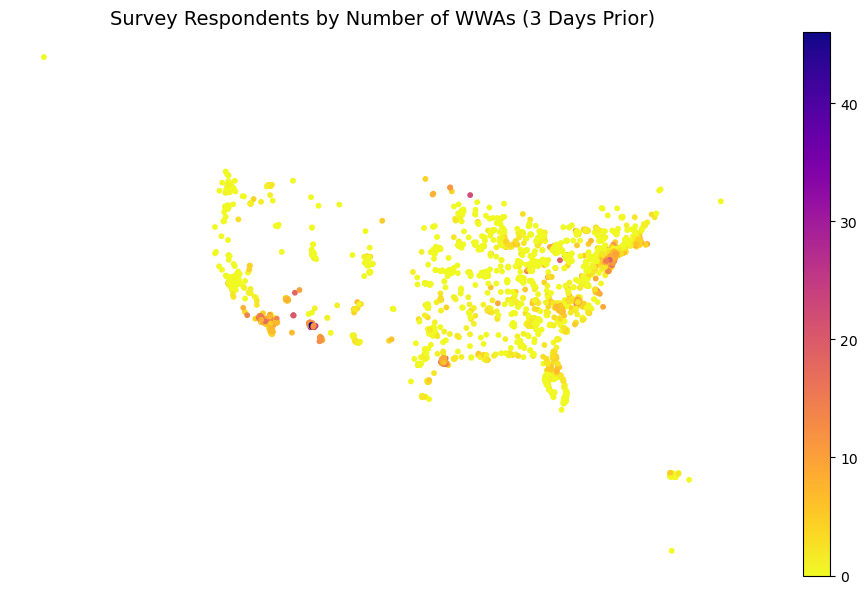

In [63]:
# Step 1: Ensure lat/lon are float (just in case)
df_18['lat'] = pd.to_numeric(df_18['lat'], errors='coerce')
df_18['lon'] = pd.to_numeric(df_18['lon'], errors='coerce')

# Step 2: Create geometry from lat/lon
geometry = [Point(xy) for xy in zip(df_18['lon'], df_18['lat'])]
gdf_18 = gpd.GeoDataFrame(df_18, geometry=geometry, crs="EPSG:4326")

# Step 3: Count WWAs
gdf_18['wwa_count'] = gdf_18['wwa_names'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Step 4: Plot
fig, ax = plt.subplots(figsize=(10, 6))
gdf_18.plot(column='wwa_count', cmap='plasma_r', legend=True, ax=ax, markersize=10)
ax.set_title("Survey Respondents by Number of WWAs (3 Days Prior)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

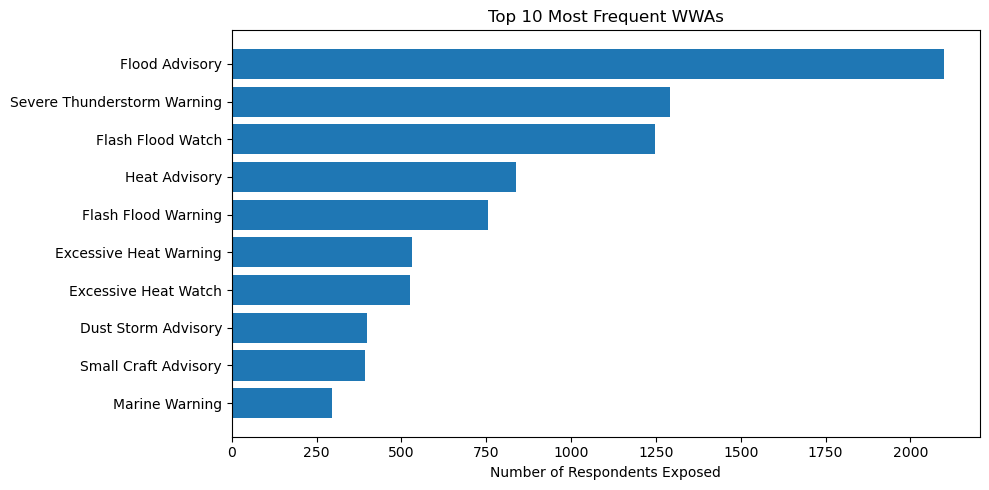

In [65]:


# Flatten and count
all_names = df_18['wwa_names'].dropna().explode()
top_names = Counter(all_names).most_common(10)

# Plot
names, counts = zip(*top_names)
plt.figure(figsize=(10, 5))
plt.barh(names[::-1], counts[::-1])
plt.title("Top 10 Most Frequent WWAs")
plt.xlabel("Number of Respondents Exposed")
plt.tight_layout()
plt.show()

In [ ]:
''' python

# Count WWAs per date
timeline = (
    df_18[['begin_date', 'wwa_names']]
    .dropna()
    .assign(wwa_count=lambda df: df['wwa_names'].apply(len))
    .groupby('begin_date')['wwa_count']
    .sum()
)

# Plot
timeline.plot(marker='o', figsize=(10, 4), title='Total WWAs by Survey Date')
plt.ylabel('Total Warnings/Watch Events')
plt.xlabel('Survey Date')
plt.grid(True)
plt.tight_layout()
plt.show()

### Step 4b: Visualizing WWWAs by Survey Reponses

For a next step, we might undertake a visualization that is a bit more involved.

Let's say we want to examine how the presence of recent weather alerts (3 days prior to taking the survey) correlates with survey respondents' perceived risk of that hazard.  Again, we're going to focus on flood-related WWAs.  How can we do that?  

Step 1.  Create two groups of respondents, those experienced a WWA prior to the survey and those who did not.
Step 2.  Extract risk perception scores for a hazard (For risk_flood: 1-No risk, 2-Low Risk.....5-Extreme risk)
Step 3.  Create comparative visualizations

For the first two steps, we have created a function **(def)** to carry out those tasks.  We could easily do this without creating a function but it would take several steps to do so.  Here we get it done in one cell.  When you run this cell, you will notice that there are no results...we're just setting things up for the visualization.

In [67]:
# --- Prep: robust WWA exposure + ordered risk labels ---

# 1) robust flood_wwa_exposure (handles NaN/non-lists)
flood_wwa_keywords = ['Flood Advisory', 'Flood Warning', 'Flash Flood Warning', 'Flash Flood Watch', 'Flood Watch']

def has_flood_wwa(wwas):
    if isinstance(wwas, (list, tuple, set)):
        return any(k in wwas for k in flood_wwa_keywords)
    return False

df_18['flood_wwa_exposure'] = df_18['wwa_names'].apply(has_flood_wwa)

# 2) numeric -> labeled flood risk (ordered categorical)
label_map = {1: 'No risk', 2: 'Low risk', 3: 'Moderate risk', 4: 'High risk', 5: 'Extreme risk'}
ordered_risk_labels = list(label_map.values())

# Coerce to numeric, map to labels, and set categorical order
df_18['risk_flood_num'] = pd.to_numeric(df_18.get('risk_flood'), errors='coerce')
df_18['risk_flood_label'] = pd.Categorical(
    df_18['risk_flood_num'].map(label_map),
    categories=ordered_risk_labels,
    ordered=True
)

#Let's take a look at what we just did

df_18[['wwa_names', 'flood_wwa_exposure', 'risk_flood_num', 'risk_flood_label']].head(10)

,wwa_names,flood_wwa_exposure,risk_flood_num,risk_flood_label
0,"[Severe Thunderstorm Warning, Flood Advisory, ...",True,3,Moderate risk
1,"[Severe Thunderstorm Warning, Flash Flood Warn...",True,2,Low risk
2,"[Heat Advisory, Heat Advisory, Heat Advisory, ...",False,2,Low risk
3,"[Red Flag Warning, Fire Weather Watch]",False,1,No risk
4,"[Beach Hazard Statement, High Surf Advisory]",False,3,Moderate risk
5,[],False,2,Low risk
6,"[High Surf Advisory, Beach Hazard Statement]",False,2,Low risk
7,"[Red Flag Warning, Red Flag Warning, Red Flag ...",True,4,High risk
8,"[Heat Advisory, Heat Advisory]",False,4,High risk
9,"[Severe Thunderstorm Warning, Severe Thunderst...",True,2,Low risk


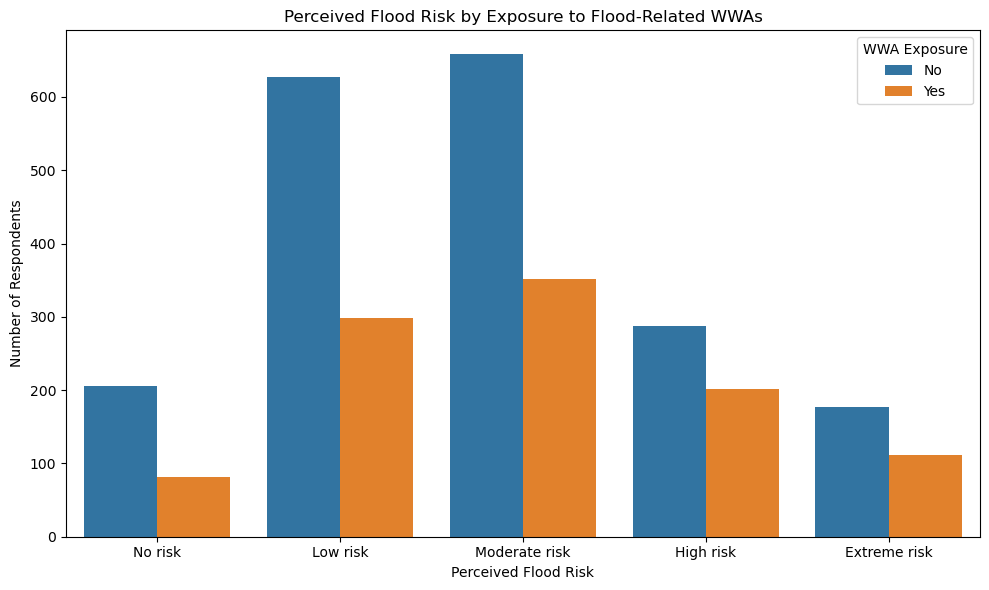

In [69]:
#let's visualize what we just did
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df_18,
    x='risk_flood_label',
    hue='flood_wwa_exposure',
    order=ordered_risk_labels,
    hue_order=[False, True]
)

plt.xlabel("Perceived Flood Risk")
plt.ylabel("Number of Respondents")
plt.title("Perceived Flood Risk by Exposure to Flood-Related WWAs")
plt.legend(title="WWA Exposure", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

In [ ]:
''' python

# crosstab -> proportions by exposure
crosstab = pd.crosstab(
    df_18['flood_wwa_exposure'],
    df_18['risk_flood_label'],
    normalize='index'
)

# ensure consistent order of rows/columns even if some levels are missing
crosstab = crosstab.reindex(index=[False, True], columns=ordered_risk_labels)

ax = crosstab.T.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6)
)

plt.title('Flood Risk Perception by WWA Exposure (Proportions)')
plt.xlabel('Perceived Flood Risk')
plt.ylabel('Proportion of Respondents')
plt.legend(title='Exposed to Flood WWA', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

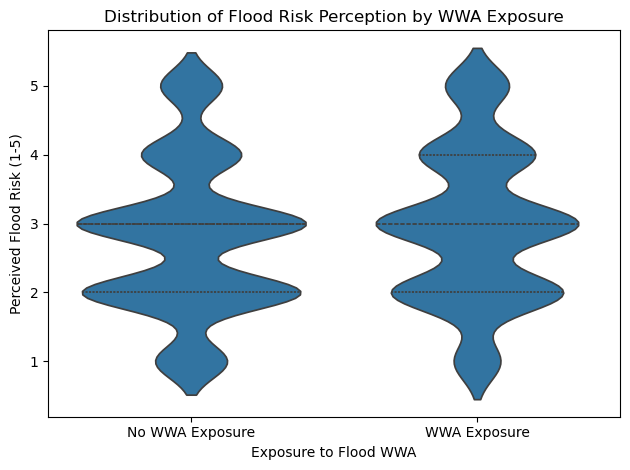

In [71]:
# Violin plots are interesting, let's take a look.  It looks a bit like a population pyramid.
sns.violinplot(data=df_18, x='flood_wwa_exposure', y='risk_flood', inner='quartile')
plt.xticks([0, 1], ['No WWA Exposure', 'WWA Exposure'])
plt.xlabel("Exposure to Flood WWA")
plt.ylabel("Perceived Flood Risk (1-5)")
plt.title("Distribution of Flood Risk Perception by WWA Exposure")
plt.tight_layout()
plt.show()

## Step 4C: Quick Statistical Analyses

We're not limited to visualizations, we can explore a number of statistical procedures to begin to test our question of whether exposure to warnings and watches has an impact on survey responses.  For this tutorial, we will run the following test:

1. Chi-Square: To evaluate whether exposure to flood-related warnings and watches and perceived flood risk categories are independent, with the p-value indicating if the observed relationship is statistically significant.

I will provide the code for two additional analysis, so you can see how they are set up.  If you want to run them on your own, just remove the first line (''' python) or put a hash (#) in front of it (#'''python).

1. Logistic Regression: To evaluate whether exposure to flood-related warnings and watches increases the odds of respondents reporting high or extreme flood risk compared to lower risk levels.
2. Ordinal Logistic Regression: To evaluate whether exposure to flood-related warnings and watches shifts respondents toward higher categories of perceived flood risk.

### 1. Chi-Square

In [73]:
# Let's create a contingency table

contingency = pd.crosstab(df_18['flood_wwa_exposure'], df_18['risk_flood_label'])
contingency

risk_flood_label,No risk,Low risk,Moderate risk,High risk,Extreme risk
flood_wwa_exposure,,,,,
False,206,627,658,287,177
True,81,299,352,202,111


In [75]:
#let's test it

chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square test")
print(f"Chi2 = {chi2:.2f}, df = {dof}, p = {p:.4f}")

Chi-square test
Chi2 = 18.94, df = 4, p = 0.0008


This suggests that the distribution of flood risk perceptions is not independent of WWA exposure — in other words, people who were exposed to flood-related weather alerts responded differently (in terms of risk levels) than those who were not exposed.

### 2. Logistic Regression

We're going to fit a logistic regression model to test whether exposure to a flood alerts predicts whether a survey respondent reports being at “high” or “extreme” flood risk.

In short: the regression asks, “How much more likely are people to report high or extreme flood risk if they were exposed to a flood-related alerts?"

In [ ]:
'''python

# Binary outcome: high risk (≥4) vs. lower
df_18['high_risk'] = df_18['risk_flood_num'] >= 4

# Predictor: WWA exposure (cast to int)
X = sm.add_constant(df_18['flood_wwa_exposure'].astype(int))
y = df_18['high_risk'].astype(int)

logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

This suggests that respondents exposed to a flood WWA had significantly higher odds (about 39% greater, exp(0.3326) ≈ 1.39) of reporting high or extreme flood risk compared to those not exposed, though the overall model explains only a small share of variation in responses.

### 3. Ordinal Logistic Regression

The previous regression was a binary logistic regression, and the outcome was simplified into two categories: high risk (4–5) vs. not high (1–3).  The model only asks: “Does exposure change the odds of being high risk or not?”

With this model, we use the full ordered scale (1-5), which accounts for the fact that reporting risk = 5 is “higher” than risk = 4, which is higher than risk = 3, etc.

Instead of focusing on a single cutoff, the model estimates the effect of exposure across all possible thresholds in the risk scale.  And you get cut-points plus one slope coefficient. The slope tells you whether exposure consistently increases the likelihood of reporting any higher category of risk.

In [77]:
# Drop NaNs to avoid issues
df_ord = df_18.dropna(subset=['risk_flood_num', 'flood_wwa_exposure'])

# Predictor must be numeric (int)
X = df_ord[['flood_wwa_exposure']].astype(int)

# Outcome is ordered categories (numeric risk levels already ordered 1–5)
y = df_ord['risk_flood_num']

# Fit ordinal logistic regression
mod = OrderedModel(y, X, distr='logit')
res = mod.fit(method='bfgs')

print(res.summary())

Optimization terminated successfully.
         Current function value: 1.471757
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
                             OrderedModel Results                             
Dep. Variable:         risk_flood_num   Log-Likelihood:                -4415.3
Model:                   OrderedModel   AIC:                             8841.
Method:            Maximum Likelihood   BIC:                             8871.
Date:                Mon, 22 Sep 2025                                         
Time:                        09:11:28                                         
No. Observations:                3000                                         
Df Residuals:                    2995                                         
Df Model:                           1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

This suggests that respondents exposed to flood-related warnings and watches had a significantly higher likelihood of placing themselves in higher flood risk perception categories (coef = 0.2810, p < 0.000), indicating a consistent upward shift in perceived risk.

## A Bit More Involved - Did WWAs *Really* Affect Risk Perception?

So it appears that exposure to watches and warnings has a statistically significant impact on survey responses.  But by how much (substantive significance)? To suggest an answer, we might look at the **predicted probabilities** of survey responses.  This shows us how much exposure to a WWA changes the likelihood of a respondent reporting “High” or “Extreme” flood risk.  

To do this, the code below creates two simple scenarios: one where a person had no flood alert (0) and one where they did (1).  It then uses a statistical model (ordinal logit model with a logit link function) to predict the probability of each risk category under those two scenarios.  The results are labeled clearly as “No Exposure” and “Exposure,” giving us a side-by-side view.  

**Analogy:** It’s like asking, “What would the risk look like if nobody had a flood alert?” and then,  “What would the risk look like if everyone had a flood alert?” — and comparing the two answers side by side.  


In [80]:
# Make two scenarios: no exposure (0) and exposure (1)
scenarios = pd.DataFrame({
    'flood_wwa_exposure': [0, 1]
})

# Predict probabilities for each risk category
pred_probs = res.predict(scenarios)

# Attach labels
pred_probs.index = ['No Exposure', 'Exposure']
pred_probs.columns = [f"Risk {c}" for c in pred_probs.columns]

pred_probs


,Risk 0,Risk 1,Risk 2,Risk 3,Risk 4
No Exposure,0.103841,0.323847,0.332512,0.152608,0.087192
Exposure,0.080450,0.280261,0.344614,0.182370,0.112304


## A possible interpretation

Respondents who were exposed to a flood WWA were less likely to report no risk (10% → 8%) or low risk (32% → 28%), and more likely to report higher levels of risk perception, particularly at the “High” (15% → 18%) and “Extreme” (9% → 11%) categories. While the percentage point changes may look modest, they indicate a clear upward shift in perceived flood risk among those who received WWAs.  In other words, I think it is possible to say that exposure to a flood warning nudged people away from saying ‘no risk’ and toward saying ‘high or extreme risk.  However, with only 3,000 responses, I probably wouldn't.  As the academics say, this requires further study. 😉

Now let's take a look at a visualization of these results.

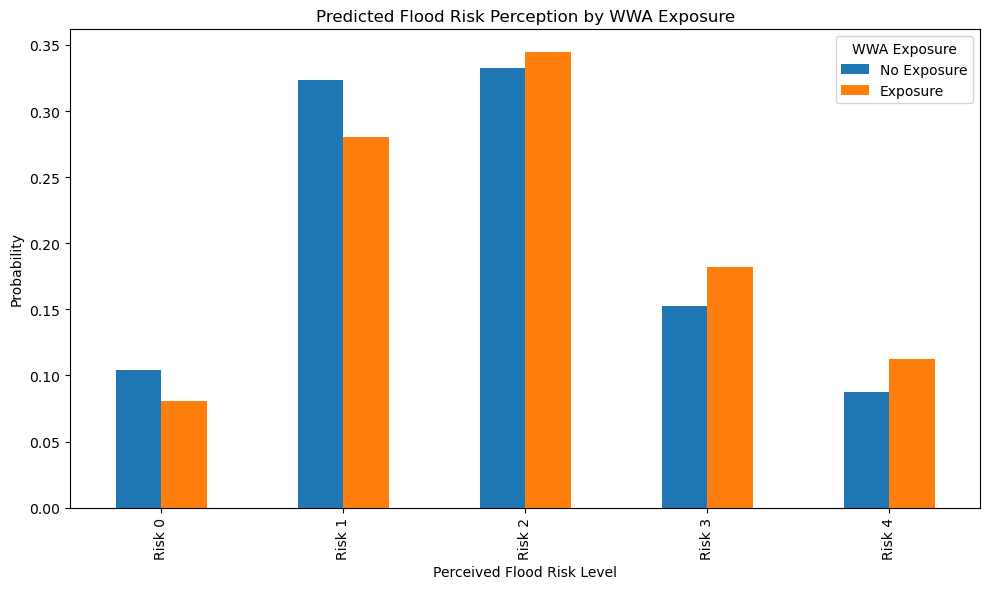

In [86]:
#let's see HOW the probability distribution shift
ax = pred_probs.T.plot(kind='bar', figsize=(10,6))
plt.title("Predicted Flood Risk Perception by WWA Exposure")
plt.ylabel("Probability")
plt.xlabel("Perceived Flood Risk Level")
plt.legend(title="WWA Exposure")
plt.tight_layout()
plt.show()

## Wrapping Up

In this tutorial, we explored how to bring together **social survey data** and **weather warning data** to better understand how hazard information might influence perceptions of risk. Using the Jupyter Notebook environment, you saw how to:  

- **Work with APIs** to search for, access, and download data programmatically  
- Organize and explore datasets interactively using python libraries like **pandas** and **requests**.  
- Merge survey data with external data from the **Iowa Environmental Mesonet**  
- Apply **geospatial tools** to handle location-based data  
- Create clear, reproducible **visualizations** and **statistical analyses** directly alongside your analysis  
- Document your process in a way that combines code, results, and explanation all in one place  

With this walkthrough, you’ve seen how Jupyter can serve as both a **research lab and a communication tool**—a space where you can work with data, analyze the data, visualize the data and results, and explain what you found.  

### Moving Forward  
- Try adapting this workflow to other survey topics (e.g., heat, drought, tornado risk)  
- Explore additional APIs to enrich your analysis with different kinds of data  
- Use Jupyter notebooks to build **reproducible reports**, where readers can see not just your conclusions but also the steps you took to get there  
- Share your notebooks with collaborators as a way to make your analysis **transparent and interactive** 

Ultimately, the key takeaway is that with just a few tools—**APIs, pandas, geospatial libraries, and Jupyter notebooks**—you can connect diverse datasets, analyze them in context, and tell meaningful data stories about risk and society **in one place**!

---

**Thank you for following along!**  
We encourage you to take this workflow and apply it to your own research questions about weather, risk, and society—the more you explore, the more insights you’ll uncover.  
